In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
import os
import warnings
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

from quantnn.models.pytorch.common import QuantileLoss

from convert_np import ComputeStatsFromNumpyFiles, ConvertDatasetToNumpy
from load_data import GOESRETRIEVALSDataset, RandomCrop, Mask, Standardize, ToTensor
from visualize.sample_plots import plotRandomSample
from models.FirstGenericNet2 import Net 
net_name = 'FirstGenericNet2' 
from models.FirstGenericNet import Net 
net_name = 'FirstGenericNet' 
#from models.persiann_CNN_rec import Net 
#net_name = 'persiann_CNN_rec' 

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device:  cpu


In [2]:
# SETUP
channels = [8, 13]
fillvalue = -1

EPOCHS = 20
BATCH_SIZE = 16

quantiles = [0.25, 0.5, 0.75] #[0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

learning_rate = 0.0001

In [3]:
# PATHS TO DATA
path_to_load_data = 'data/first_net_dataset/origin/'#'/home/ingrid/Dendrite/UserAreas/Ingrid/Dataset/' 
path_to_save_data = 'data/first_net_dataset/'
path_to_save_state_dict = 'models/saved_models/'

In [4]:
path_to_load_train_data = path_to_load_data + 'train/'
path_to_save_train_data = path_to_save_data + 'train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_train_data).parent, Path('stats.npy'))

path_to_load_val_data = path_to_load_data + 'validation/'
path_to_save_val_data = path_to_save_data + 'validation/npy_files'

path_to_load_test_data = path_to_load_data + 'test/'
path_to_save_test_data = path_to_save_data + 'test/npy_files'

In [5]:
def importData(channels, BATCH_SIZE, path_to_load_data, path_to_save_data, path_to_stats):
    ConvertDatasetToNumpy(path_to_load_data = path_to_load_data,
                      path_to_save_data = path_to_save_data)

    dataset = GOESRETRIEVALSDataset(
        path_to_data = path_to_save_data,
        channels = channels, 
        transform = transforms.Compose([Mask(), RandomCrop(128),
                                        Standardize(path_to_save_data, path_to_stats, channels),
                                        ToTensor()])
    )

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return(dataset, dataloader)

In [6]:
train_dataset, train_dataloader = importData(channels, BATCH_SIZE, path_to_load_train_data, 
                                              path_to_save_train_data, path_to_stats)

In [7]:
val_dataset, val_dataloader = importData(channels, BATCH_SIZE, path_to_load_val_data, 
                                              path_to_save_val_data, path_to_stats)

414

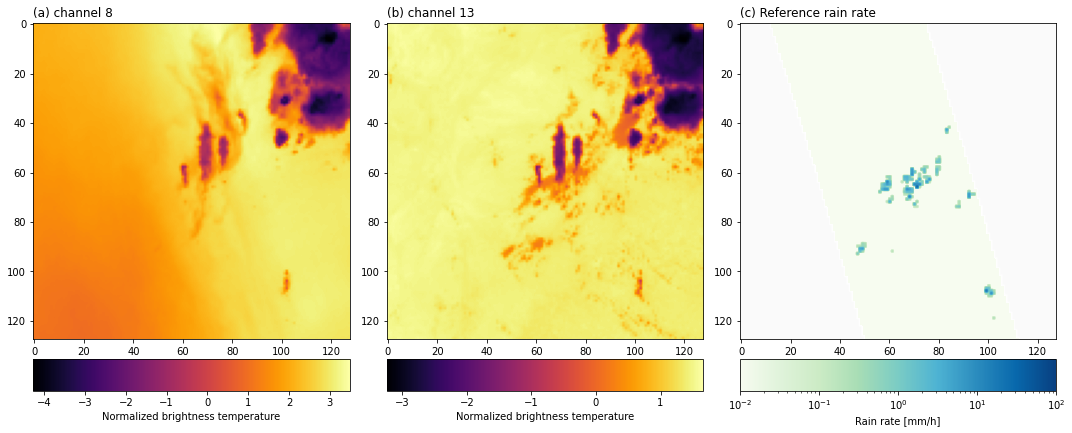

In [8]:
# PLOT RANDOM SAMPLE
plotRandomSample(train_dataset)

197

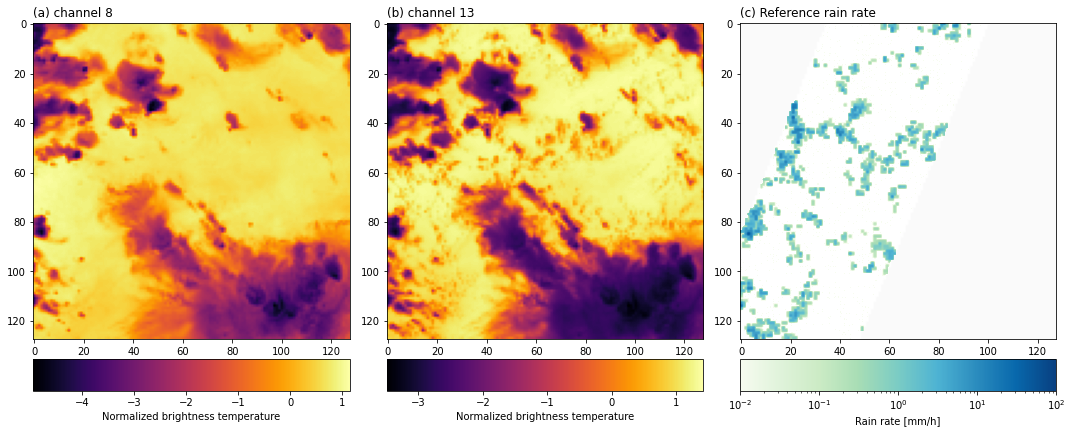

In [9]:
plotRandomSample(val_dataset)

In [10]:
net = Net(len(quantiles), len(channels))
net.to(device)

criterion = QuantileLoss(quantiles=quantiles, mask=fillvalue)
criterion.to(device=device)
optimizer = SGD(net.parameters(), lr = learning_rate)

In [11]:
# TRAINING
def train(model, X, y, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    output = model(X)

    loss = criterion(output, y.unsqueeze(1))
    loss.backward()
    
    optimizer.step()

    return loss

In [12]:
t=train_dataset[0]['box']
p = torch.flatten(t, start_dim=1)
p=p.unsqueeze(1)
print(p.shape)
p.transpose(2,1).shape

torch.Size([2, 1, 16384])


torch.Size([2, 16384, 1])

In [13]:
writer = SummaryWriter()

p_val = 5
best_val_loss = np.inf
for epoch in range(EPOCHS):
    
    epoch_loss = 0
    train_bar = tqdm(train_dataloader)
    train_bar.set_description("Epoch %d, train" % epoch)
    for train_batch_index, train_batch in enumerate(train_bar): 
        X = train_batch['box'].to(device)
        y = train_batch['label'].to(device)

        train_batch_loss = train(net, X, y, optimizer, criterion)
        epoch_loss += train_batch_loss.item()
        
        av_train_batch_loss = epoch_loss/(train_batch_index+1)
        train_bar.set_postfix({'train batch loss': av_train_batch_loss})
    
    av_train_loss = epoch_loss/len(train_dataset)
    writer.add_scalar('Loss/train', av_train_loss, epoch)
    
    if(epoch % p_val == 0):
        with torch.no_grad():
            net.eval()
            val_loss = 0
            val_bar = tqdm(val_dataloader)
            val_bar.set_description("Epoch %d, val" % epoch)
            for val_batch_index, val_batch in enumerate(val_bar):

                X = val_batch['box'].to(device).detach()
                y = val_batch['label'].to(device).detach()

                output = net(X)

                val_batch_loss = criterion(output, y.unsqueeze(1))

                val_loss += val_batch_loss.item()

                av_val_batch_loss = val_loss/(val_batch_index+1)
                val_bar.set_postfix({'val batch loss': av_val_batch_loss})

            av_val_loss = val_loss/len(val_dataset)
            writer.add_scalar('Loss/val', av_val_loss, epoch)

        if(best_val_loss>val_loss):
            best_val_loss = val_loss
            best_net = net.state_dict()


Epoch 19, train: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it, train batch loss=0.183]


In [14]:
# SAVE MODEL
path_to_state_dict = path_to_save_state_dict +  net_name + '_state_dict-' + 'lr_' + str(learning_rate) + '-' + datetime.now().strftime("%m-%d-%YT%H:%M:%S") + '.pt'
print(path_to_state_dict)
torch.save(net.state_dict(), path_to_state_dict)

models/saved_models/FirstGenericNet_state_dict-lr_0.0001-03-25-2021T10:05:28.pt


In [15]:
# LOAD MODEL
#net = Net(len(quantiles), len(channels))
#net.load_state_dict(torch.load('models/saved_models/FirstGenericNet_state_dict-03-23-2021T19:44:34.pt'))
#net.to(device)

0.5
index  45


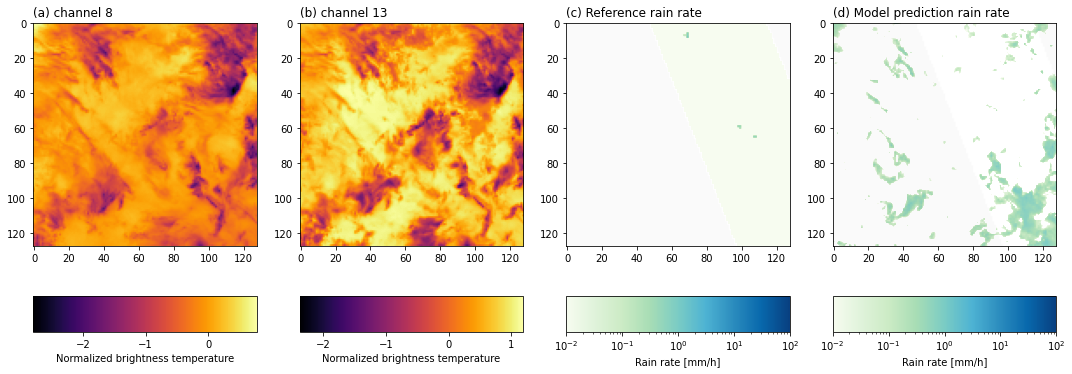

In [21]:
# PLOT RANDOM SAMPLE AND PREDICTION
quantile_num=int(len(quantiles)/2)
print(quantiles[quantile_num])
ind = plotRandomSample(val_dataset, net=net, quantile_num=quantile_num, device=device)
print('index ', ind)

In [17]:
quantile_num=int(len(quantiles)/2)
y_true = []
y_pred = []
with torch.no_grad():
    for batch_index, batch in enumerate(val_dataloader):

        y_true += [batch['label'].detach().numpy()]
        
        X = batch['box'].to(device).detach()
        y_pred += [net(X)[:,quantile_num].cpu().detach().numpy()]

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

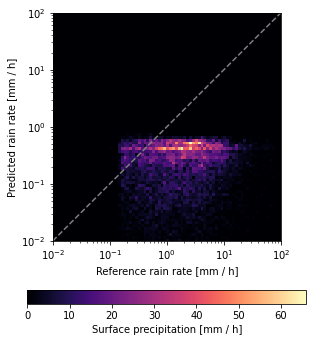

In [18]:
bins = np.logspace(-2, 2, 81)
indices = y_true >= 0.0


freqs, _, _ = np.histogram2d(y_true[indices], y_pred[indices], bins=bins)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)

f, axs = plt.subplots(figsize=(5, 6))

ax = axs
p = ax.pcolormesh(bins, bins, freqs.T,
                  #norm=norm,  
                  cmap=plt.get_cmap('magma'))
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
#ax.set_title("(a) Title", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
ax.set_aspect(1.0)


In [19]:
print('Non zero rain to all rain ratio (true): ', np.sum(y_true[indices]!=0.)/len(y_true[indices]))
print('Non zero rain to all rain ratio (pred): ', np.sum(y_pred[indices]!=0.)/len(y_pred[indices]))

TP = np.sum(y_pred[indices][(y_true[indices]!=0.)]!=0.)
FN = np.sum(y_pred[indices][(y_true[indices]!=0.)]==0.)
FP = np.sum(y_pred[indices][(y_true[indices]==0.)]!=0.)
TN = np.sum(y_pred[indices][(y_true[indices]==0.)]==0.)

TPR = TP/(TP+FN)
print(TPR)
FPR = FP/(FP+TN)
print(FPR)

ACC = (TP+TN)/(TP+FN+FP+TN)
print(ACC)

Non zero rain to all rain ratio (true):  0.06805215102959544
Non zero rain to all rain ratio (pred):  1.0
1.0
1.0
0.06805215102959544


In [20]:
print(len(y_true[indices]))
print(len(val_dataset))


1497190
238
